Using Smopy means using OpenStreetMaps.  Per their usage rules: "Heavy use (e.g. distributing an app that uses tiles from openstreetmap.org) is forbidden without prior permission from the System Administrators. "

http://wiki.openstreetmap.org/wiki/Tile_usage_policy

In [1]:
import networkx as nx
import json
import numpy as np
import pandas as pd
import json
import smopy
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = mpl.rcParams['savefig.dpi'] = 300

## Defining the functions

In [2]:
"""
    Each edge in the graph contains information about the road, including a list of points along this road. 
    We first create a function that returns this array of coordinates, for any edge in the graph.
"""

def get_path(n0, n1):
    """If n0 and n1 are connected nodes in the graph, this function
    return an array of point coordinates along the road linking
    these two nodes."""
    return np.array(json.loads(g[n0][n1]['Json'])['coordinates'])

In [3]:
"""
    Our path contains connected nodes in the graph. 
    Every edge between two nodes is characterized by a list of points (constituting a part of the road). 
    Therefore, we need to define a function that concatenates the positions along every edge in the path. 
    A difficulty is that we need to concatenate the positions in the right order along our path. 
    We choose the order based on the fact that the last point in an edge needs to be close to the first point in the next edge.
"""

def get_full_path(path):
    """Return the positions along a path."""
    p_list = []
    curp = None
    for i in range(len(path)-1):
        p = get_path(path[i], path[i+1])
        if curp is None:
            curp = p
        if np.sum((p[0]-curp)**2) > np.sum((p[-1]-curp)**2):
            p = p[::-1,:]
        p_list.append(p)
        curp = p[-1]
    return np.vstack(p_list)

In [4]:
#plot nodes, a function sometimes called in plt_edge
def plt_node(a,b, color='black', size=1):
    
    for x,y in zip(a,b):
        ax.plot(x,y, 'o', color=color, ms=size, markeredgewidth=0.0)

In [317]:
def plt_edge(mini_path, color, plot_nodes=False, width=0.5):
    mini_linepath = get_full_path(mini_path)
    mx, my = map.to_pixels(mini_linepath[:,1], mini_linepath[:,0])
    ax.plot(mx, my, '-k', lw=width, color=color)
    if plot_nodes:
        plt_node(mx, my)

## Work with data

Load the data (a Shapefile dataset) with NetworkX. 
This dataset contains detailed information about all roads in San Francisco County. 
NetworkX's read_shp function returns a graph, where each node is a geographical position, 
and each edge contains information about the road linking the two nodes.

In lieu of Census data, SF Gov has a full, connected graph of streets that can be found here: https://data.sfgov.org/Geographic-Locations-and-Boundaries/Streets-of-San-Francisco/4ugn-hf48

In [6]:
g = nx.read_shp('Road files/geo_export_4d537b7d-a470-4eb9-b147-1d0ea89e6b60.shp')

#being directional means being unable to find edges unless in correct order
#so switch to unidirected
g = g.to_undirected()

## Connect home and work

In [9]:
home = (37.790461, -122.428311)
work = (37.789006, -122.409448)

8920 nodes
Lowered zoom level to keep map size reasonable. (z = 12)


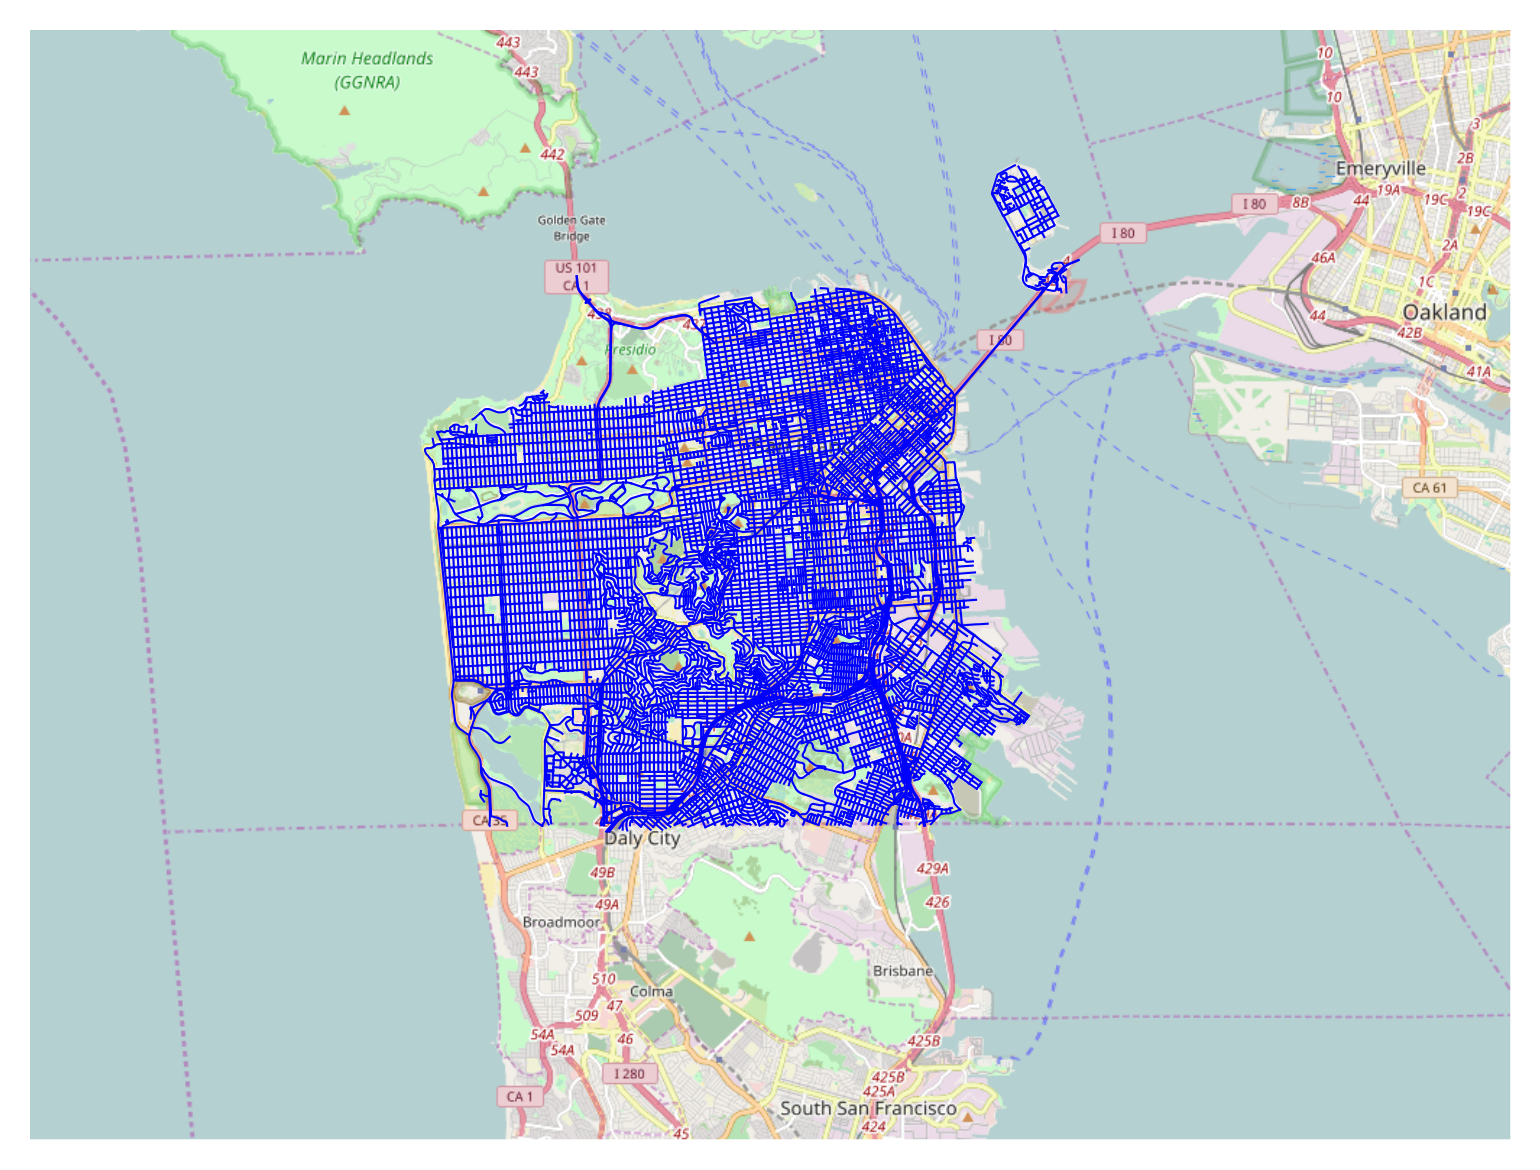

In [320]:
#grab the biggest subgraph
max_len = -1
sg_final = sg_all[0]
for sg in sg_all:
    x = len(sg)
    if x > max_len:
        max_len = x
        sg_final = sg
        
sg = sg_final

#verify it
print(str(len(sg)) + ' nodes')

pos0 = (37.809776, -122.520686)
pos1 = (37.710163, -122.316753)
map = smopy.Map(pos0, pos1)
ax = map.show_mpl()

for e in sg_final.edges_iter():
    plt_edge(e, 'blue')

We will notably use the road path to compute its length. 
We first need to define a function that computes the distance between any two points in geographical coordinates. 
This function has been found in StackOverflow. 
http://stackoverflow.com/questions/8858838/need-help-calculating-geographical-distance

In [322]:
#returns in KILOMETERS
EARTH_R = 6372.8
def geocalc(lat0, lon0, lat1, lon1):
    """Return the distance (in km) between two points in 
    geographical coordinates."""
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    dlon = lon0 - lon1
    y = np.sqrt(
        (np.cos(lat1) * np.sin(dlon)) ** 2
         + (np.cos(lat0) * np.sin(lat1) 
         - np.sin(lat0) * np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    return EARTH_R * c

In [323]:
#Now, we define a function computing a path's length.

#order of lats, lons was incorrect in tutorial! Corrected here
def get_path_length(path):
    return np.sum(geocalc(path[:-1,1], path[:-1,0], path[1:,1], path[1:,0]))

In [324]:
"""
    Now, we update our graph by computing the distance between any two connected nodes. 
    We add this information in the distance attribute of the edges.
"""
for n0, n1 in sg_final.edges_iter():
    path = get_path(n0, n1)
    distance = get_path_length(path)
    sg.edge[n0][n1]['distance'] = distance

In [325]:
"""
    The last step before we can find the shortest path in the graph, 
    is to find the two nodes in the graph that are closest to the two requested positions.
"""

nodes = np.array(sg_final.nodes())
# Get the closest nodes in the graph.
pos0_i = np.argmin(np.sum((nodes[:,::-1] - work)**2, axis=1))
pos1_i = np.argmin(np.sum((nodes[:,::-1] - home)**2, axis=1))

In [326]:
"""
    Now, we use NetworkX's shortest_path function to compute the shortest path between our two positions. 
    We specify that the weight of every edge is the length of the road between them.
"""

# Compute the shortest path.
path = nx.shortest_path(sg_final, 
                        source=tuple(nodes[pos0_i]), 
                        target=tuple(nodes[pos1_i]),
                        weight='distance correct')
len(path)

18

In [327]:
"""
    The itinerary has been computed. 
    The path variable contains the list of edges that form the shortest path between our two positions. 
    Now, we can get information about the itinerary with Pandas. 
    The dataset has a few fields of interest, including the name and type (State, Interstate, etc.) of the roads.
"""

roads = pd.DataFrame([sg.edge[path[i]][path[i + 1]] 
                      for i in range(len(path) - 1)], 
                     columns=['distance', 'nhood', 'streetname', 'Json'])
roads

distance                    nhood     streetname  \
0   0.146293    Downtown - Tenderloin      SUTTER ST   
1   0.147393    Downtown - Tenderloin      SUTTER ST   
2   0.146373    Downtown - Tenderloin      SUTTER ST   
3   0.146200    Downtown - Tenderloin      SUTTER ST   
4   0.145881    Downtown - Tenderloin      SUTTER ST   
5   0.146989    Downtown - Tenderloin      SUTTER ST   
6   0.052496  Van Ness - Civic Center        POLK ST   
7   0.137053  Van Ness - Civic Center        FERN ST   
8   0.056962  Van Ness - Civic Center   VAN NESS AVE   
9   0.055898  Van Ness - Civic Center   VAN NESS AVE   
10  0.137391  Van Ness - Civic Center      AUSTIN ST   
11  0.146205  Van Ness - Civic Center      AUSTIN ST   
12  0.145341     Lower Pacfic Heights      AUSTIN ST   
13  0.051746     Lower Pacfic Heights     OCTAVIA ST   
14  0.107783     Lower Pacfic Heights     OCTAVIA ST   
15  0.104089          Pacific Heights     OCTAVIA ST   
16  0.146378          Pacific Heights  SACRAMENTO ST   

                                                 Json  
0   { "type": "LineString", "coordinates": [ [ -12...  
1   { "type": "LineString", "coordinates": [ [ -12...  
2   { "type": "LineString", "coordinates": [ [ -12...  
3   { "type": "LineString", "coordinates": [ [ -12...  
4   { "type": "LineString", "coordinates": [ [ -12...  
5   { "type": "LineString", "coordinates": [ [ -12...  
6   { "type": "LineString", "coordinates": [ [ -12...  
7   { "type": "LineString", "coordinates": [ [ -12...  
8   { "type": "LineString", "coordinates": [ [ -12...  
9   { "type": "LineString", "coordinates": [ [ -12...  
10  { "type": "LineString", "coordinates": [ [ -12...  
11  { "type": "LineString", "coordinates": [ [ -12...  
12  { "type": "LineString", "coordinates": [ [ -12...  
13  { "type": "LineString", "coordinates": [ [ -12...  
14  { "type": "LineString", "coordinates": [ [ -12...  
15  { "type": "LineString", "coordinates": [ [ -12...  
16  { "type": "LineString", "coordinates": [ [ -12...

In [329]:
"""
    Here is the total length (IN KILOMETERS) of this itinerary.
"""

print('km: ' + str(roads['distance'].sum()))
print('mi: ' + str(roads['distance'].sum() * 0.621371))

km: 2.020470685190046
mi: 1.255461890127224


In [330]:
#need to pull an appropriate window size for graphing
#this finds the lowest & highest lat/lon even if not directly paired
ll_lat = home[0]
ll_lon = home[1]
ur_lat = home[0]
ur_lon = home[1]

for p in path:
    if p[1] < ll_lat:
        ll_lat = p[1]
    if p[0] < ll_lon:
        ll_lon = p[0]
    if p[1] > ur_lat:
        ur_lat = p[1]
    if p[0] > ur_lon:
        ur_lon = p[0]

path_ll = (ll_lat, ll_lon)
path_ur = (ur_lat, ur_lon)
        
        
print(path_ll)
print(path_ur)

(37.78775665251701, -122.42909226863561)
(37.79066690670631, -122.41024243821914)


Lowered zoom level to keep map size reasonable. (z = 16)


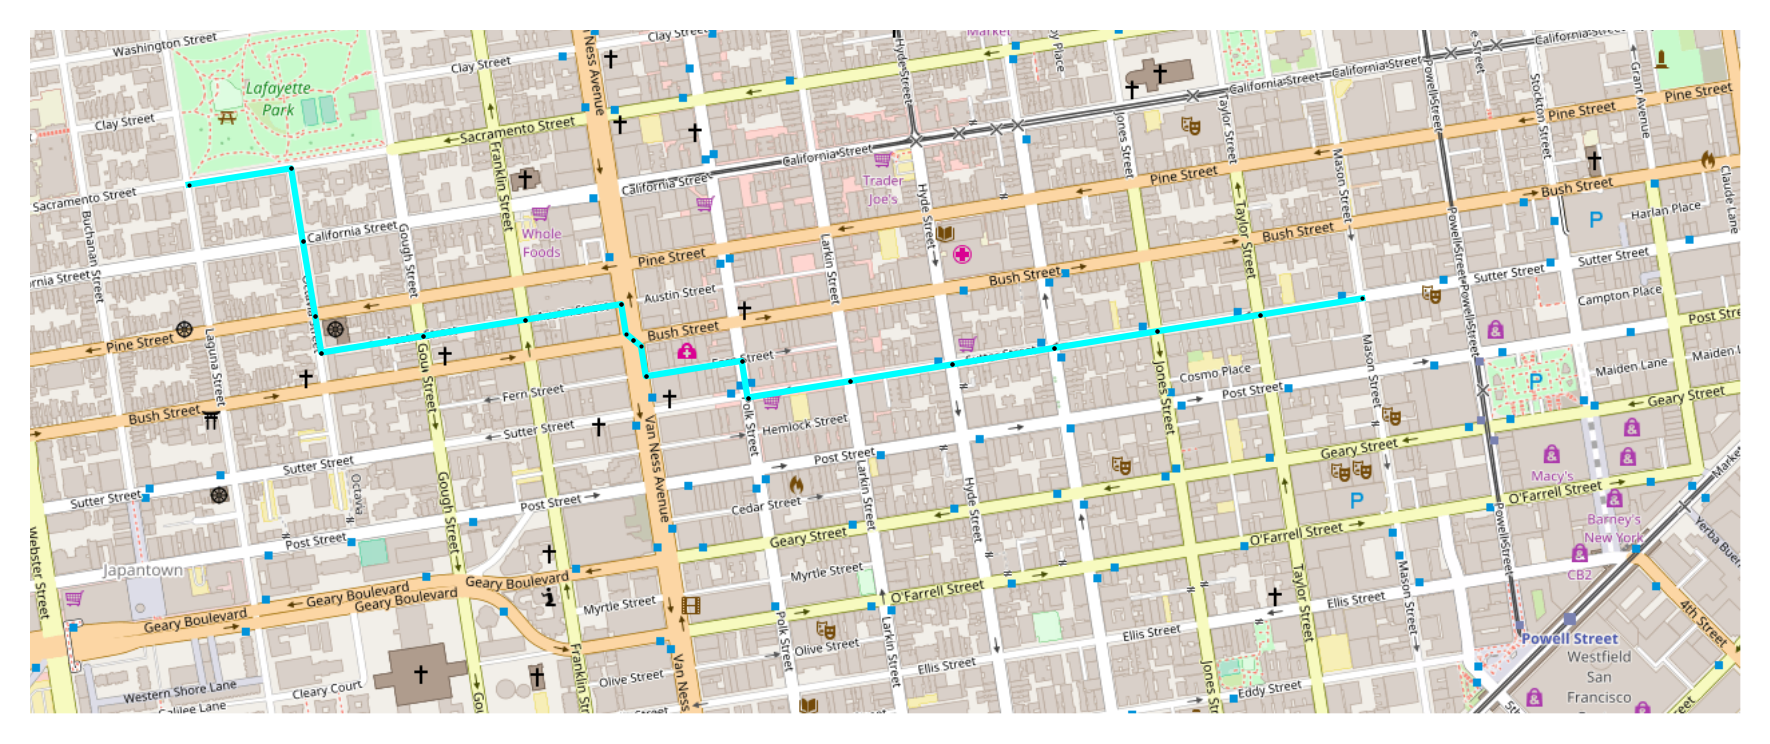

In [334]:
"""
    Finally, let display the itinerary on the map. We first retrieve the map with Smopy.
"""
map = smopy.Map(path_ll, path_ur)

ax = map.show_mpl()
plt_edge(path, 'cyan', True, width=1.5)

## scratch

In [274]:
np.argmin(roads['distance correct'])

9

In [230]:
haversine(roads.start[0][1], roads.start[0][0], roads.start[1][1],roads.start[1][0] )

0.14625147625725174

'\n0: Sutter: Mason -> Taylor\n1: Taylor -> Jones\n2: Jones -> Leavenworth\n3: Leavenworth -> Hyde\n4: Hyde -> Larkin\n5: Larkin -> Polk\n6: Turn onto Polk -> Fern\n7: Turn onto Fern -> Van Ness\n8: Fern -> Bush\n9: Bush -> Austin\n10: Turn onto Austin -> Franklin\n11: Franklin -> Gough\n12: Gough -> Octavia\n13: Turn onto Octavia -> Pine\n14: Pine -> California\n15: California -> Sacramento\n16: \n'

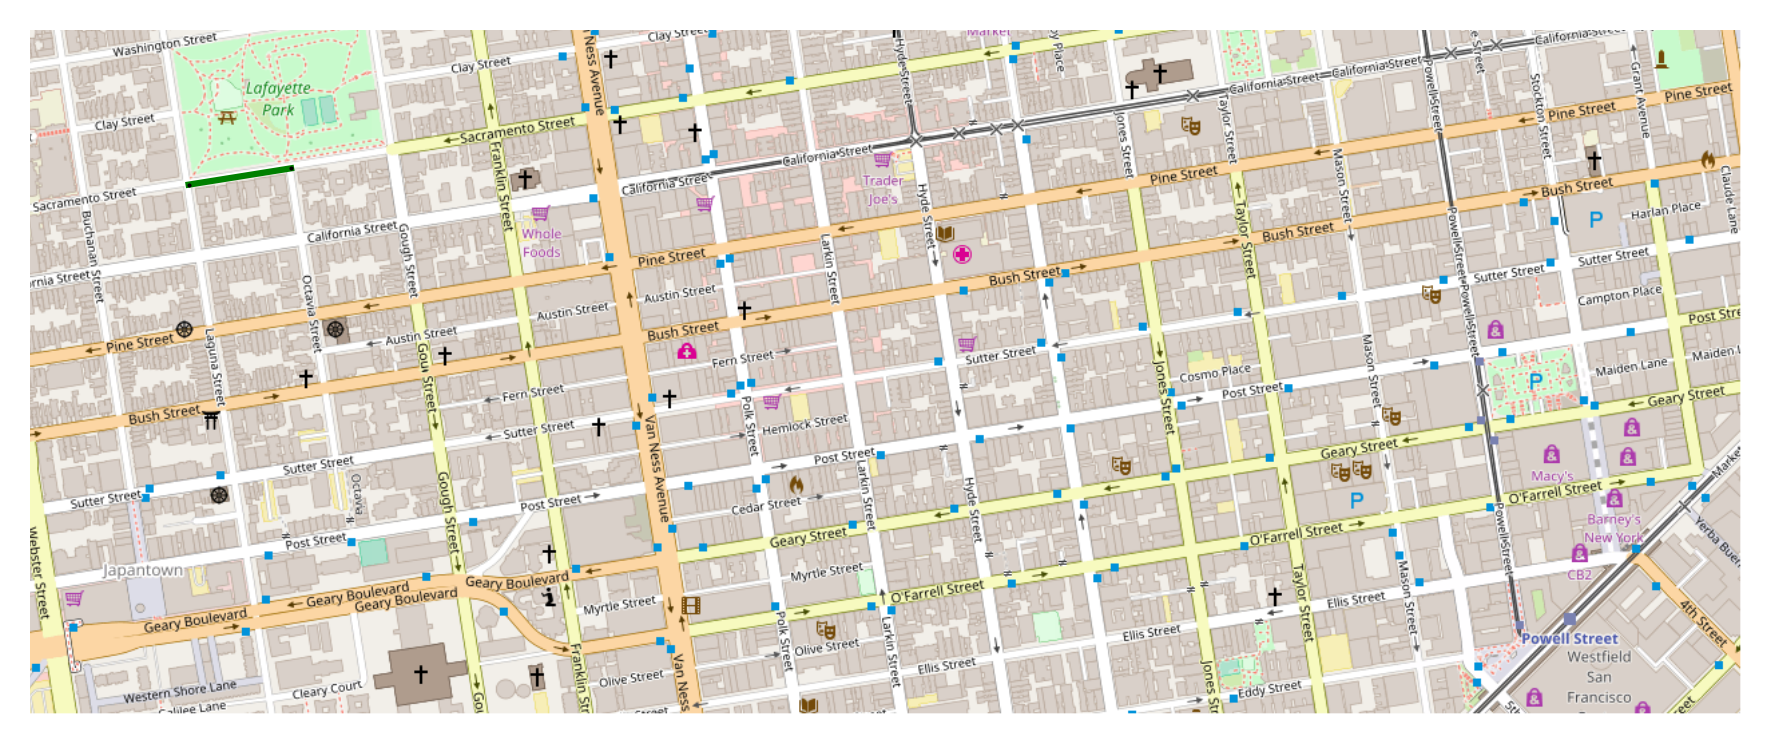

In [121]:
ax = map.show_mpl()
plt_edge((roads.start[16], roads.stop[16]), 'green', True)

"""
0: Sutter: Mason -> Taylor
1: Taylor -> Jones
2: Jones -> Leavenworth
3: Leavenworth -> Hyde
4: Hyde -> Larkin
5: Larkin -> Polk
6: Turn onto Polk -> Fern
7: Turn onto Fern -> Van Ness
8: Fern -> Bush
9: Bush -> Austin
10: Turn onto Austin -> Franklin
11: Franklin -> Gough
12: Gough -> Octavia
13: Turn onto Octavia -> Pine
14: Pine -> California
15: California -> Sacramento
16: Turn onto Sacramento -> Laguna
"""

In [202]:
haversine(37.78901634,-122.41024244, 37.78880754, -122.41188566 )

0.14625165070684218

In [292]:
n0 = path[9]
n1 = path[10]

tmp_path = get_path(n0, n1)
print(tmp_path)
print(n0)
print(n1)

[[-122.40806655   37.78399149]
 [-122.40816046   37.78397271]
 [-122.40893089   37.78336426]
 [-122.40895216   37.78328785]]
(-122.40806654669208, 37.78399148665078)
(-122.40895215893948, 37.78328785291907)


In [293]:
print(tmp_path[1:,0], tmp_path[1:,1], tmp_path[:-1,0], tmp_path[:-1,1])
print(geocalc(tmp_path[1:,0], tmp_path[1:,1], tmp_path[:-1,0], tmp_path[:-1,1]))

[-122.40816046 -122.40893089 -122.40895216] [ 37.78397271  37.78336426  37.78328785] [-122.40806655 -122.40816046 -122.40893089] [ 37.78399149  37.78397271  37.78336426]
[ 0.01050523  0.09305219  0.00513259]


In [297]:
print(tmp_path[:-1,1], tmp_path[:-1,0], tmp_path[1:,1], tmp_path[1:,0])
print(np.sum(geocalc(tmp_path[:-1,1], tmp_path[:-1,0], tmp_path[1:,1], tmp_path[1:,0])))

[ 37.78399149  37.78397271  37.78336426] [-122.40806655 -122.40816046 -122.40893089] [ 37.78397271  37.78336426  37.78328785] [-122.40816046 -122.40893089 -122.40895216]
0.112959867852


In [235]:
print(np.sum(haversine(tmp_path[1:,0], tmp_path[1:,1], tmp_path[:-1,0], tmp_path[:-1,1])))

0.183140917905


In [291]:
tmp_path = path[9:11]
tmp_path

[(-122.40806654669208, 37.78399148665078),
 (-122.40895215893948, 37.78328785291907)]